In [5]:
import tensorflow as tf
import os
import cv2
import imghdr
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, auc, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [10]:
import tensorflow as tf

# Check available GPUs
tf.config.list_physical_devices('GPU')

# Verify GPU acceleration
tf.test.is_gpu_available()

False

In [7]:
data_dir = "D:\Mini Project\ImageClassification\data3"
image_exts = ["jpeg", "jpg", "bmp", "png"]
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print("Image not in ext list {}".format(image_path))
                os.remove(image_path)
        except Exception as e:
            print("Issue with image {}".format(image_path))

data = tf.keras.utils.image_dataset_from_directory(
    "D:\Mini Project\ImageClassification\data3"
)

KeyboardInterrupt: 

9
<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


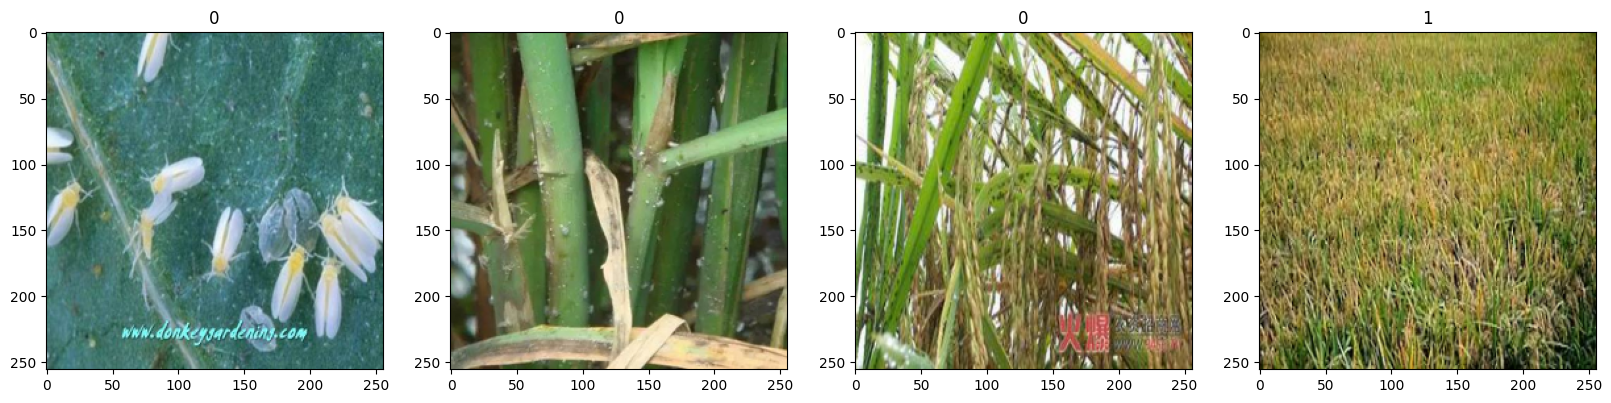

In [ ]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)
print(train_size)
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)
print(train)

In [ ]:
# ML Model
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation="relu", input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile("adam", loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [ ]:
logdir = "D:\Mini Project\ImageClassification\logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Reduce learning rate on plateau callback
reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss", factor=0.1, patience=3, verbose=1
)

In [ ]:
hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback, reduce_lr_callback],
)

Epoch 1/20
9/9 [==============================] - 19s 2s/step - loss: 0.9194 - accuracy: 0.4896 - val_loss: 0.6880 - val_accuracy: 0.6094 - lr: 0.0010
Epoch 2/20
9/9 [==============================] - 13s 1s/step - loss: 0.6817 - accuracy: 0.6215 - val_loss: 0.6941 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/20
9/9 [==============================] - 11s 1s/step - loss: 0.6570 - accuracy: 0.6250 - val_loss: 0.6348 - val_accuracy: 0.6406 - lr: 0.0010
Epoch 4/20
9/9 [==============================] - 9s 953ms/step - loss: 0.6248 - accuracy: 0.6389 - val_loss: 0.6256 - val_accuracy: 0.7656 - lr: 0.0010
Epoch 5/20
9/9 [==============================] - 10s 955ms/step - loss: 0.6051 - accuracy: 0.6944 - val_loss: 0.4985 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 6/20
9/9 [==============================] - 10s 984ms/step - loss: 0.5300 - accuracy: 0.7674 - val_loss: 0.4700 - val_accuracy: 0.7969 - lr: 0.0010
Epoch 7/20
9/9 [==============================] - 10s 986ms/step - loss: 0.5256 - accu

In [ ]:
val_loss, val_acc = model.evaluate(val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

2/2 [==============================] - 1s 194ms/step - loss: 0.1871 - accuracy: 0.9531
Validation Loss: 0.1871
Validation Accuracy: 0.9531


In [ ]:
# Model evaluation
y_true = []
y_scores = []

for batch in test.as_numpy_iterator():
    X, y = batch
    y_hat = model.predict(X)
    y_true.extend(y)
    y_scores.extend(y_hat)

y_true = np.array(y_true)
y_scores = np.array(y_scores)

1/1 [==============================] - 0s 251ms/step


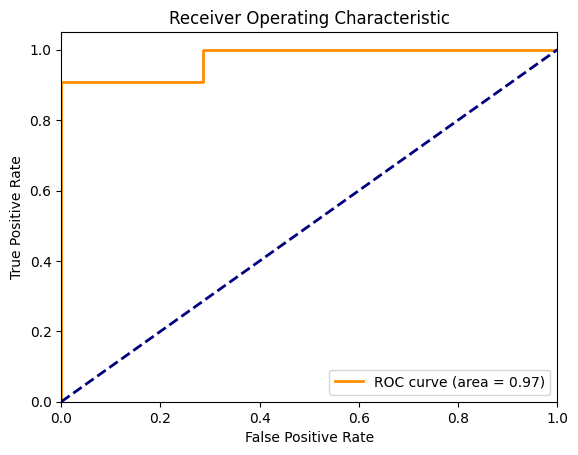

In [ ]:
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color="darkorange", lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

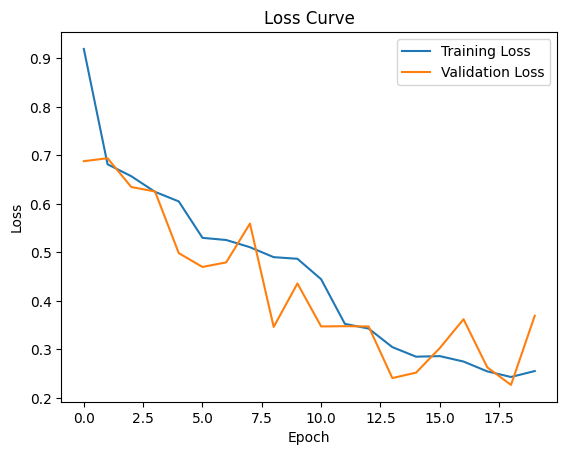

In [ ]:
# Loss curve
plt.figure()
plt.plot(hist.history["loss"], label="Training Loss")
plt.plot(hist.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.show()

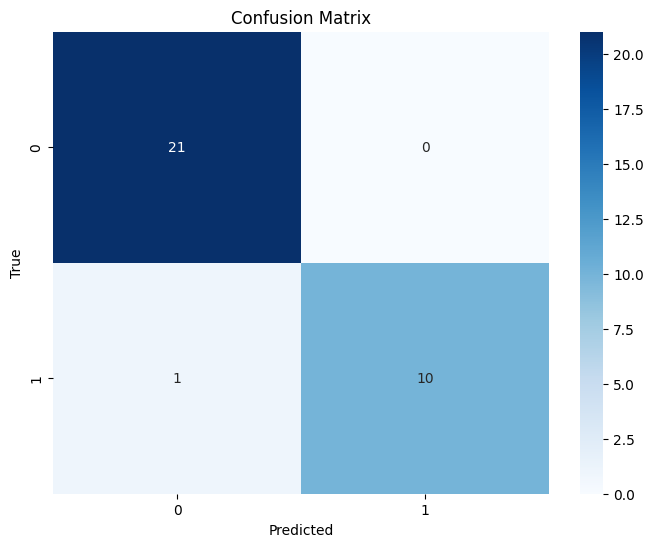

In [ ]:
import seaborn as sns
# Confusion matrix
y_pred = np.round(y_scores)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

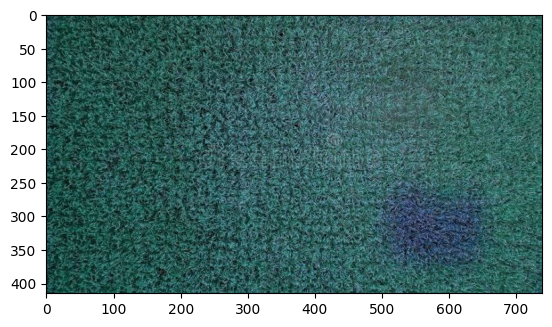

1/1 [==============================] - 0s 78ms/step


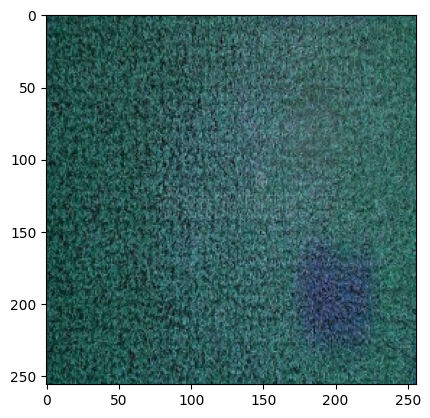

In [ ]:
img = cv2.imread(
    "D:\Mini Project\ImageClassification\data\Infected\photo_3_2023-04-18_20-05-18.jpg"
)
plt.imshow(img)
plt.show()
resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
yhat = model.predict(np.expand_dims(resize / 255, 0))

In [ ]:
print(yhat)
if yhat > 0.5:
    print(f"Predicted class is Not Infected")
else:
    print(f"Predicted class is Infected")


[[0.23770809]]
Predicted class is Infected


In [ ]:
from tensorflow.keras.models import load_model

model.save(os.path.join("D:\Mini Project\ImageClassification", "imageclassifier.h5"))
